In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import os
import matplotlib.pyplot as plt

### Pre-factoSig
Read / inspect in the preprocessed adata before factosig (dim reduction)

In [2]:
pipe_h5ad = '/home/minhang/mds_project/data/cohort_adata/adata_mrd_standardized_oct7.h5ad'
adata_pipe = sc.read_h5ad(pipe_h5ad)

In [3]:
adata_pipe

AnnData object with n_obs × n_vars = 60118 × 15679
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'library', 'exp.ID', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_dsb', 'nFeature_dsb', 'nCount_ADT', 'nFeature_ADT', 'hash.ID', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'Lane', 'patient', 'marker', 'Time', 'batch', 'Tech', 'sample', 'source', 'soup.singlet_posterior', '_indices', '_scvi_batch', '_scvi_labels', 'predicted.annotation', 'predicted.annotation.score', 'predicted.pseudotime', 'predicted.pseudotime.score', 'CN.label', 'Days from SCT', 'Days.from.Relapse', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'ID', 'modality', 'chr', 'start', 'end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells

### Post-factoSig
1. Factosig fitting result: factosig_fit_k100_oct7.npz (contains loadings, scores, and metadata) is saved. 
    a. Read in the factosig_fit_k100_oct7.npz and augment it with the preprocessed adata before factosig "adata_mrd_standardized_oct7.h5ad". \
        i. Need to double check the augmentation/integration process to make sure that gene names and cell barcodes are correctly ordered, ask AI how to do it? 
    b. 

Then use the AnnData writer io in factosig/ to write the FA results into my Anndata


In [4]:
import numpy as np
import anndata as ad
from factosig.io.anndata_io import to_anndata

In [3]:
fit_npz = "/home/minhang/mds_project/data/cohort_adata/factosig_fit_k100_oct7.npz"
# Load cached fit
npz = np.load(fit_npz)
L = np.asarray(npz["loadings"])  # (p, k)
Z = np.asarray(npz["scores"])    # (n, k)
mu = np.asarray(npz["mu"])       # (p,)
psi = np.asarray(npz["psi"])     # (p,)
V = np.asarray(npz["V"])         # (k, k)
genes_fit = npz.get("genes")

In [8]:
print(len(genes_fit))
# print the dimension of L, Z, mu, psi, V
print(L.shape, Z.shape, mu.shape, psi.shape, V.shape)


15679
(15679, 100) (60118, 100) (15679,) (15679,) (100, 100)


In [5]:
input_h5ad = "/home/minhang/mds_project/data/cohort_adata/adata_mrd_standardized_oct7.h5ad"
# Load AnnData
adata = ad.read_h5ad(input_h5ad)

In [7]:
adata

AnnData object with n_obs × n_vars = 60118 × 15679
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'library', 'exp.ID', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_dsb', 'nFeature_dsb', 'nCount_ADT', 'nFeature_ADT', 'hash.ID', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'Lane', 'patient', 'marker', 'Time', 'batch', 'Tech', 'sample', 'source', 'soup.singlet_posterior', '_indices', '_scvi_batch', '_scvi_labels', 'predicted.annotation', 'predicted.annotation.score', 'predicted.pseudotime', 'predicted.pseudotime.score', 'CN.label', 'Days from SCT', 'Days.from.Relapse', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'ID', 'modality', 'chr', 'start', 'end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells

In [ ]:
output_h5ad = "/home/minhang/mds_project/data/cohort_adata/adata_mrd_factosig_fit_only_k100_oct7.h5ad"
# Align genes to cached fit (if present)
if genes_fit is not None:
    genes_fit = [g.decode("utf-8") if isinstance(g, (bytes, bytearray)) else str(g) for g in genes_fit]
    name_to_idx = {g: i for i, g in enumerate(list(adata.var_names))}
    missing = [g for g in genes_fit if g not in name_to_idx]
    if missing:
        raise RuntimeError(f"AnnData missing {len(missing)} fit genes, e.g., {missing[:5]}")
    adata = adata[:, genes_fit].copy()

# Minimal provenance meta
meta = {
    "model": "gaussian-fa",
    "rotation": "varimax",
    "seed": int(npz.get("seed", 0)),
    "n_factors": int(npz.get("n_factors", L.shape[1])),
}

# Write loadings/scores into AnnData (varm/obsm/uns)
to_anndata(
    adata,
    L=L,
    Z=Z,
    z=None,  # add later after bootstrap
    q=None,  # add later after bootstrap
    stab=None,  # add later after bootstrap
    meta=meta,
    loadings_key="fs_loadings",
    scores_key="fs_scores",
    z_key="fs_loading_z",
    q_key="fs_loading_q",
    stab_key="fs_loading_stability",
    meta_key="fs_meta",
)

# Optional: compute diagnostics for your plotting code
ss_loadings_per_factor = (L ** 2).sum(axis=0)
communality = (L ** 2).sum(axis=1)

adata.uns.setdefault("fa", {})
adata.uns["fa"]["ss_loadings_per_factor"] = ss_loadings_per_factor
adata.var["communality"] = communality
adata.var["uniqueness"] = psi  # optional

adata.write(output_h5ad)
print(f"Wrote FA results to {output_h5ad}")

Wrote FA results to /home/minhang/mds_project/data/cohort_adata/adata_mrd_factosig_fit_only_k100_oct7.h5ad


#### Sanity check on alignment of factosig fit result and adata gene / cell barcode orders

In [1]:
import numpy as np
import scanpy as sc

# Paths
h5ad_path = "/home/minhang/mds_project/data/cohort_adata/adata_mrd_factosig_fit_only_k100_oct7.h5ad"
fit_npz = "/home/minhang/mds_project/data/cohort_adata/factosig_fit_k100_oct7.npz"

# Load once
adata = sc.read_h5ad(h5ad_path)
npz = np.load(fit_npz)

# What preprocessing happened before fit?
# - X was read as float32
# - Optional top-variance gene cap via --max-genes (keeps order of selected genes)
# - No additional sorting; the exact chosen gene order was saved to npz["genes"]
print(f"[fit_cache] keys: {list(npz.keys())}")

# Verify gene order match (if 'genes' exists)
genes_fit = npz.get("genes")
if genes_fit is not None:
    genes_fit = [g.decode("utf-8") if isinstance(g, (bytes, bytearray)) else str(g) for g in genes_fit]
    # adata in this file should already be subset/reordered to genes_fit from prior integration step
    same_length = len(genes_fit) == adata.n_vars
    same_order = same_length and np.all(adata.var_names.values == np.array(genes_fit))
    print("genes length match:", same_length)
    print("genes order match:", bool(same_order))
    if not same_order:
        # Surface the first mismatches to help debugging; do NOT modify adata here
        mism_i = np.where(adata.var_names.values != np.array(genes_fit))[0][:10]
        print("Example gene mismatches at indices:", mism_i)
else:
    print("No 'genes' saved in npz; assuming same gene order as input h5ad used for fitting.")

# Verify cells: the fit used the rows of the input h5ad; we normally preserve cell order.
# We can't check barcodes from the npz (not saved), so assert only the expected Z shape
Z = np.asarray(npz["scores"])
print("cells in adata:", adata.n_obs, "rows in Z:", Z.shape[0])

[fit_cache] keys: ['loadings', 'scores', 'mu', 'psi', 'V', 'genes', 'n_factors', 'device', 'seed']
genes length match: True
genes order match: True
cells in adata: 60118 rows in Z: 60118


In [3]:
L = np.asarray(adata.varm["fs_loadings"])
Z_adata = np.asarray(adata.obsm["fs_scores"])

print("L shape:", L.shape, "Z shape:", Z_adata.shape)

# Basic consistency
p, k = L.shape
assert Z.shape[1] == k, "Score dimension k does not match loadings"
assert Z_adata.shape == Z.shape, "Scores in adata do not match cached Z shape"

# Store simple diagnostics if missing
if "fa" not in adata.uns:
    adata.uns["fa"] = {}
if "ss_loadings_per_factor" not in adata.uns["fa"]:
    adata.uns["fa"]["ss_loadings_per_factor"] = (L ** 2).sum(axis=0)
if "communality" not in adata.var:
    adata.var["communality"] = (L ** 2).sum(axis=1)

# print whether 
print("Diagnostics loading and scores present:",
      "ss_loadings_per_factor" in adata.uns["fa"],
      "communality" in adata.var)

L shape: (15679, 100) Z shape: (60118, 100)
Diagnostics loading and scores present: True True


### Read in the factoSig loading and cell score matrix containing adata
Do some diagnostics

In [4]:
# Cell 1 — Load once and prepare FA-derived fields
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

h5ad_path = "/home/minhang/mds_project/data/cohort_adata/adata_mrd_factosig_fit_only_k100_oct7.h5ad"
fit_npz = "/home/minhang/mds_project/data/cohort_adata/factosig_fit_k100_oct7.npz"

adata = sc.read_h5ad(h5ad_path)

# FA results already integrated
L = np.asarray(adata.varm["fs_loadings"])   # (p, k)
Z = np.asarray(adata.obsm["fs_scores"])     # (n, k)

# Load cached parameters once (for posterior/t-score and fit diagnostics)
npz = np.load(fit_npz)
mu  = np.asarray(npz["mu"])
psi = np.asarray(npz["psi"])
V   = np.asarray(npz["V"])

# Derived quantities; store on adata
adata.uns.setdefault("fa", {})
adata.uns["fa"]["ss_loadings_per_factor"] = (L**2).sum(axis=0)
adata.var["communality"] = (L**2).sum(axis=1)
adata.var["uniqueness"] = psi
adata.obsm["fs_t_scores"] = Z / (np.sqrt(np.diag(V))[None, :] + 1e-12)  # optional normalized scores

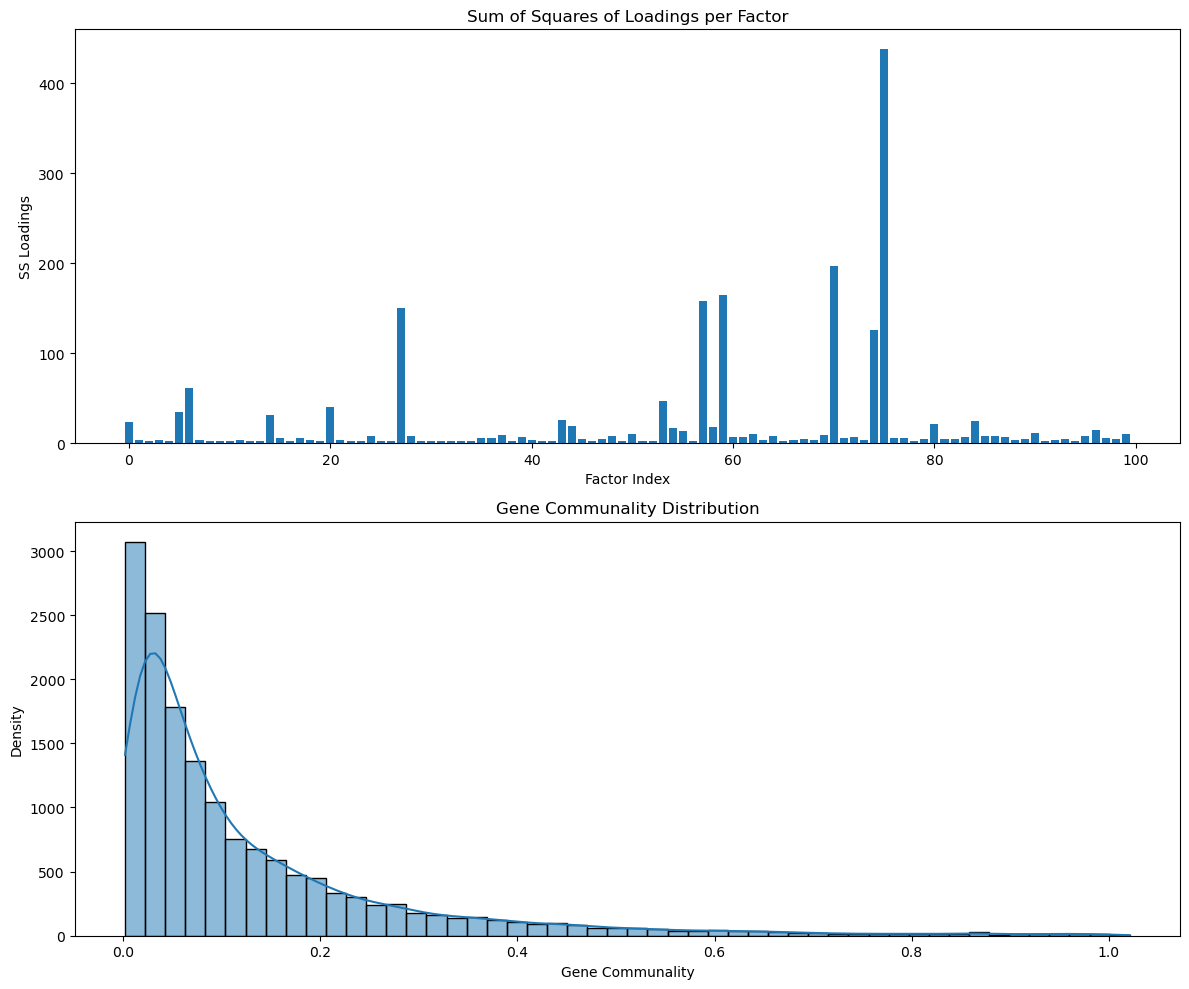

In [5]:
# Cell 2 — Diagnostic plots: SS by factor and gene communality
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
axes[0].bar(range(len(adata.uns["fa"]["ss_loadings_per_factor"])),
            adata.uns["fa"]["ss_loadings_per_factor"])
axes[0].set_title("Sum of Squares of Loadings per Factor")
axes[0].set_xlabel("Factor Index")
axes[0].set_ylabel("SS Loadings")

sns.histplot(adata.var["communality"], ax=axes[1], bins=50, kde=True)
axes[1].set_title("Gene Communality Distribution")
axes[1].set_xlabel("Gene Communality")
axes[1].set_ylabel("Density")
plt.tight_layout()
plt.show()

In [11]:
# Cell 3 — Sanity checks (no reloads)
ss_per_factor = adata.uns["fa"]["ss_loadings_per_factor"]
communality = adata.var["communality"].to_numpy()
print("sum SS factors:", float(ss_per_factor.sum()))
print("sum communalities:", float(communality.sum()))
frac = ss_per_factor / ss_per_factor.sum()
print("Top-10 factors’ SS fraction:", float(np.sort(frac)[-10:].sum()))
R = np.corrcoef(Z, rowvar=False)
off_diag_max = np.max(np.abs(R - np.eye(Z.shape[1])))
print("Max |corr(Z) off-diagonal|:", float(off_diag_max))

sum SS factors: 1994.9719568886478
sum communalities: 1994.9719568886458
Top-10 factors’ SS fraction: 0.7100605591528054
Max |corr(Z) off-diagonal|: 0.058912959616634834


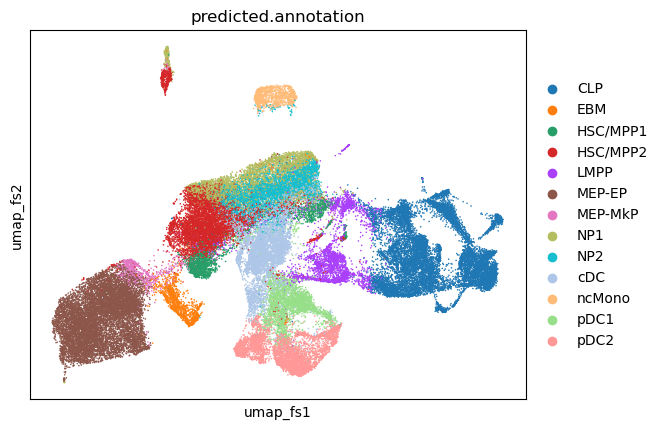

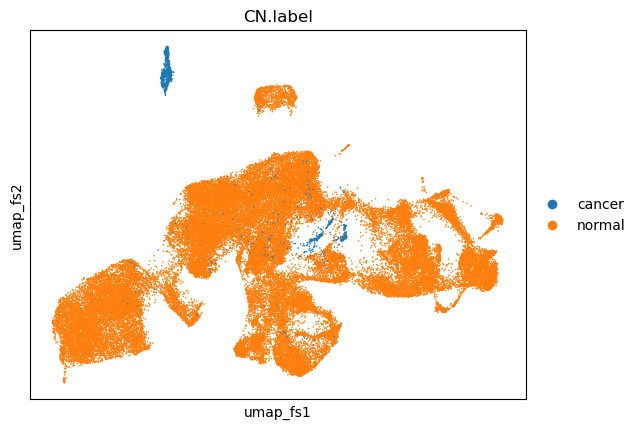

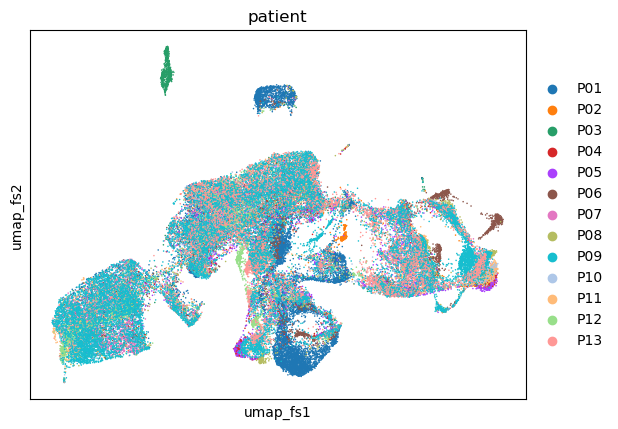

In [12]:
# Cell 4 — Neighbors + UMAP using FA representation
rep = "fs_t_scores" if "fs_t_scores" in adata.obsm else "fs_scores"
X = adata.obsm[rep]
if rep != "fs_t_scores":
    X = (X - X.mean(axis=0)) / (X.std(axis=0, ddof=1) + 1e-9)
adata.obsm["X_fs"] = X.astype(np.float32)

sc.pp.neighbors(adata, use_rep="X_fs", n_neighbors=30, metric="euclidean", key_added="fs")
sc.tl.umap(adata, neighbors_key="fs", min_dist=0.3, random_state=0, key_added="umap_fs")

sc.pl.embedding(adata, basis="umap_fs", color=["predicted.annotation"],
                legend_loc="right margin", wspace=0.35, size=5)
sc.pl.embedding(adata, basis="umap_fs", color=["CN.label"],
                legend_loc="right margin", wspace=0.35, size=5)
sc.pl.embedding(adata, basis="umap_fs", color=["patient"],
                legend_loc="right margin", wspace=0.35, size=5)

In [13]:
# Cell 5 — Factor–label association (η²) using the same FA representation
def eta2_per_factor(Zmat, labels):
    cat = pd.Categorical(labels)
    codes = cat.codes
    valid = codes >= 0
    Zmat = np.asarray(Zmat)[valid]
    codes = codes[valid]
    n_groups = len(cat.categories)
    k = Zmat.shape[1]
    eta2 = np.empty(k, dtype=float)
    counts = np.bincount(codes, minlength=n_groups)
    for j in range(k):
        y = Zmat[:, j]
        gm = y.mean()
        ss_total = np.sum((y - gm) ** 2)
        if ss_total <= 0:
            eta2[j] = np.nan
            continue
        sums = np.bincount(codes, weights=y, minlength=n_groups)
        means = np.divide(sums, counts, out=np.zeros_like(sums), where=counts > 0)
        ss_between = np.sum(counts * (means - gm) ** 2)
        eta2[j] = ss_between / ss_total
    return pd.Series(eta2, name="eta2").sort_values(ascending=False)

Z_for_assoc = adata.obsm["X_fs"]
eta_pred = eta2_per_factor(Z_for_assoc, adata.obs["predicted.annotation"])
eta_cn = eta2_per_factor(Z_for_assoc, adata.obs["CN.label"])
eta_patient = eta2_per_factor(Z_for_assoc, adata.obs["patient"])
print("Top η² (predicted.annotation):"); print(eta_pred.head(10))

Top η² (predicted.annotation):
27    0.853218
53    0.792338
57    0.769837
0     0.732596
6     0.717614
70    0.670934
20    0.631259
62    0.423184
14    0.408583
28    0.325435
Name: eta2, dtype: float64


In [14]:
# Cell 6 — Fit diagnostics using this same AnnData (reconstruction and residuals)
X_data = adata.X.A if hasattr(adata.X, "A") else adata.X
X_data = np.asarray(X_data, dtype=np.float32)

Xhat = mu + Z @ L.T
res = X_data - Xhat
res_var = res.var(axis=0, ddof=1)

corr = np.corrcoef(res_var, psi)[0, 1]
print("Corr(residual variance, psi):", float(corr))

x_var = X_data.var(axis=0, ddof=1)
r2_gene = 1.0 - (res_var / (x_var + 1e-12))
print("Median gene R^2:", float(np.median(r2_gene)))

Corr(residual variance, psi): 0.999762334064229
Median gene R^2: 0.06700733473522247


### After Boostrap finishes, integrate significance result with the adata

In [2]:
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
post_bootstrap_h5ad = "/home/minhang/mds_project/data/cohort_adata/adata_mrd_factosig_bootstrap_oct7.h5ad"
post_bootstrap_adata = sc.read_h5ad(post_bootstrap_h5ad)

# Extract FA + bootstrap fields
L = np.asarray(post_bootstrap_adata.varm["fs_loadings"])               # (p, k)
Z = np.asarray(post_bootstrap_adata.obsm["fs_scores"])                 # (n, k)
Z_loading = np.asarray(post_bootstrap_adata.varm["fs_loading_z"])      # (p, k)
Q = np.asarray(post_bootstrap_adata.varm["fs_loading_q"])              # (p, k) FDR q-values
stab = np.asarray(post_bootstrap_adata.varm["fs_loading_stability"])   # (p, k)

p, k = L.shape
print("Shapes L/Z/z/q/stab:", L.shape, Z.shape, Z_loading.shape, Q.shape, stab.shape)

Shapes L/Z/z/q/stab: (15679, 100) (60118, 100) (15679, 100) (15679, 100) (15679, 100)


In [3]:
post_bootstrap_adata.varm['fs_loading_stability'].shape

(15679, 100)

In [4]:
# Cell 2 — Quick bootstrap diagnostics
# 1) per-factor # of significant genes (q < 0.05, 0.1)
sig_005 = (Q < 0.05).sum(axis=0)
sig_010 = (Q < 0.10).sum(axis=0)
print("Median #sig(q<0.05) per factor:", int(np.median(sig_005)))
print("Median #sig(q<0.10) per factor:", int(np.median(sig_010)))
print("Total number of genes per factor:", L.shape[0])

# 2) per-factor stability summary (fraction of genes above threshold)
frac_stab_0p5 = (stab > 0.5).mean(axis=0)
print("Median frac(stability>0.5) per factor:", float(np.median(frac_stab_0p5)))

# 3) simple |L| vs significance coupling on top factors (ids of top factors by #sig)
top_factors = np.argsort(-sig_005)[:5]
print("Top factors by #sig(q<0.05):", top_factors.tolist())

Median #sig(q<0.05) per factor: 2524
Median #sig(q<0.10) per factor: 3269
Total number of genes per factor: 15679
Median frac(stability>0.5) per factor: 0.011129536322469546
Top factors by #sig(q<0.05): [70, 59, 57, 75, 27]


In [5]:
# Cell 3 — Count significance "hits across the board"
# - per-factor counts at multiple thresholds
# - per-gene count of significant factors (how many factors each gene is significant for)

thresholds = [0.01, 0.05, 0.10]
for t in thresholds:
    print(f"q < {t}: median per-factor significant genes = {int(np.median((Q < t).sum(axis=0)))}")

sig_count_per_gene = (Q < 0.05).sum(axis=1)  # across factors
print("Median factors-per-gene with q<0.05:", int(np.median(sig_count_per_gene)))

q < 0.01: median per-factor significant genes = 1554
q < 0.05: median per-factor significant genes = 2524
q < 0.1: median per-factor significant genes = 3269
Median factors-per-gene with q<0.05: 24


In [3]:
# Cell 4 — Build per-factor ranked lists: score = -log10(q-val) * loading
# since q-val is multiple testing corrected, it is more conservative than p-val

Q = np.clip(Q, 1e-300, 1.0) # clip q-val to avoid inf
# Ranking score: signed loading weighted by -log10(p)
score = -np.log10(Q) * L   # (p, k), preserves gene order in adata.var_names

# Build per-factor pandas Series
gene_names = post_bootstrap_adata.var_names.to_numpy()
ranked_per_factor = {
    f"factor_{j}": pd.Series(score[:, j], index=gene_names).sort_values(ascending=False)
    for j in range(k)
}

# Optional: write .rnk files for GSEA preranked
# out_dir = "/home/minhang/mds_project/data/cohort_adata/gsea_preranked_oct7"
# Path(out_dir).mkdir(parents=True, exist_ok=True)
# for j, s in ranked_per_factor.items():
#     s.to_csv(f"{out_dir}/{j}.rnk", sep="\t", header=False)

In [18]:
len(ranked_per_factor["factor_0"])

15679

### Run GSEA using the ranked list
- Compare multiplying loading value with q-val 
- Just use the loading value

In [18]:
# Build rankers: rank = -log10(q) * loading
import gseapy as gp
from pathlib import Path

Qc = np.clip(Q, 1e-300, 1.0)
rank = -np.log10(Qc) * L
ranked_per_factor = {
    f"factor_{j}": pd.Series(rank[:, j], index=gene_names).sort_values(ascending=False)
    for j in range(k)
}

gene_sets = "/home/minhang/mds_project/data/cohort_adata/gene_sets/h.all.v2024.1.Hs.symbols.gmt"
out_root = "/home/minhang/mds_project/data/cohort_adata/gsea_results_factosig_bootstrap_oct7/comb_sig_n_loading/"
Path(out_root).mkdir(parents=True, exist_ok=True)

selected = range(k)  # or a subset like top factors by #sig genes
summary = {} # store the number of significant pathways for each factor
for name, series in ranked_per_factor.items():
    out_dir = Path(out_root) / name
    out_dir.mkdir(parents=True, exist_ok=True)
    df_rnk = series.reset_index()
    df_rnk.columns = ["gene", "score"]
    res = gp.prerank(
        rnk=df_rnk,
        gene_sets=gene_sets,
        processes=4,
        permutation_num=1000,
        outdir=str(out_dir),
        seed=0,
        min_size=10,
        max_size=5000,
        no_plot=True,
        format="png",
    )
    res_df = res.res2d
    summary[name] = int((res_df["FDR q-val"] < 0.05).sum())

pd.Series(summary).sort_values(ascending=False)

/tmp/ipykernel_1677084/3487307871.py:23: DeprecationWarning: processes is deprecated; use threads
  res = gp.prerank(
/tmp/ipykernel_1677084/3487307871.py:23: DeprecationWarning: processes is deprecated; use threads
  res = gp.prerank(
/tmp/ipykernel_1677084/3487307871.py:23: DeprecationWarning: processes is deprecated; use threads
  res = gp.prerank(
/tmp/ipykernel_1677084/3487307871.py:23: DeprecationWarning: processes is deprecated; use threads
  res = gp.prerank(
/tmp/ipykernel_1677084/3487307871.py:23: DeprecationWarning: processes is deprecated; use threads
  res = gp.prerank(
/tmp/ipykernel_1677084/3487307871.py:23: DeprecationWarning: processes is deprecated; use threads
  res = gp.prerank(
/tmp/ipykernel_1677084/3487307871.py:23: DeprecationWarning: processes is deprecated; use threads
  res = gp.prerank(
/tmp/ipykernel_1677084/3487307871.py:23: DeprecationWarning: processes is deprecated; use threads
  res = gp.prerank(
/tmp/ipykernel_1677084/3487307871.py:23: DeprecationWarn

factor_53    15
factor_30    11
factor_70     8
factor_10     5
factor_84     4
             ..
factor_61     0
factor_62     0
factor_63     0
factor_64     0
factor_0      0
Length: 100, dtype: int64

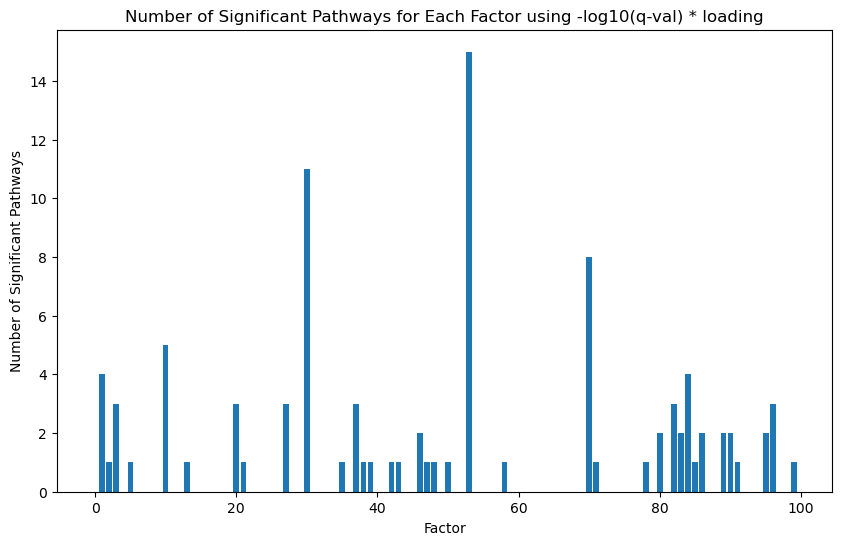

In [19]:
# plot the number of significant pathways for each factor
plt.figure(figsize=(10, 6))
# x-axis just use a number 0, 1, 2, ..., k-1
plt.bar(range(k), list(summary.values()))
plt.xlabel("Factor")
plt.ylabel("Number of Significant Pathways")
plt.title("Number of Significant Pathways for Each Factor using -log10(q-val) * loading")
plt.show()

In [14]:
loading_rank = L
loading_ranked_per_factor = {
    f"factor_{j}": pd.Series(loading_rank[:, j], index=gene_names).sort_values(ascending=False)
    for j in range(k)
}

gene_sets = "/home/minhang/mds_project/data/cohort_adata/gene_sets/h.all.v2024.1.Hs.symbols.gmt"
out_root = "/home/minhang/mds_project/data/cohort_adata/gsea_results_factosig_bootstrap_oct7/just_loading/"
Path(out_root).mkdir(parents=True, exist_ok=True)

selected = range(k)  # or a subset like top factors by #sig genes
summary = {} # store the number of significant pathways for each factor
for name, series in loading_ranked_per_factor.items():
    out_dir = Path(out_root) / name
    out_dir.mkdir(parents=True, exist_ok=True)
    df_rnk = series.reset_index()
    df_rnk.columns = ["gene", "score"]
    res = gp.prerank(
        rnk=df_rnk,
        gene_sets=gene_sets,
        processes=4,
        permutation_num=1000,
        outdir=str(out_dir),
        seed=0,
        min_size=10,
        max_size=5000,
        no_plot=True,
        format="png",
    )
    res_df = res.res2d
    summary[name] = int((res_df["FDR q-val"] < 0.05).sum())

pd.Series(summary).sort_values(ascending=False)

/tmp/ipykernel_1677084/270666032.py:18: DeprecationWarning: processes is deprecated; use threads
  res = gp.prerank(
/tmp/ipykernel_1677084/270666032.py:18: DeprecationWarning: processes is deprecated; use threads
  res = gp.prerank(
/tmp/ipykernel_1677084/270666032.py:18: DeprecationWarning: processes is deprecated; use threads
  res = gp.prerank(
/tmp/ipykernel_1677084/270666032.py:18: DeprecationWarning: processes is deprecated; use threads
  res = gp.prerank(
/tmp/ipykernel_1677084/270666032.py:18: DeprecationWarning: processes is deprecated; use threads
  res = gp.prerank(
/tmp/ipykernel_1677084/270666032.py:18: DeprecationWarning: processes is deprecated; use threads
  res = gp.prerank(
/tmp/ipykernel_1677084/270666032.py:18: DeprecationWarning: processes is deprecated; use threads
  res = gp.prerank(
/tmp/ipykernel_1677084/270666032.py:18: DeprecationWarning: processes is deprecated; use threads
  res = gp.prerank(
/tmp/ipykernel_1677084/270666032.py:18: DeprecationWarning: proc

factor_70    31
factor_6     31
factor_53    29
factor_85    23
factor_37    21
             ..
factor_67     0
factor_92     0
factor_63     0
factor_72     0
factor_31     0
Length: 100, dtype: int64

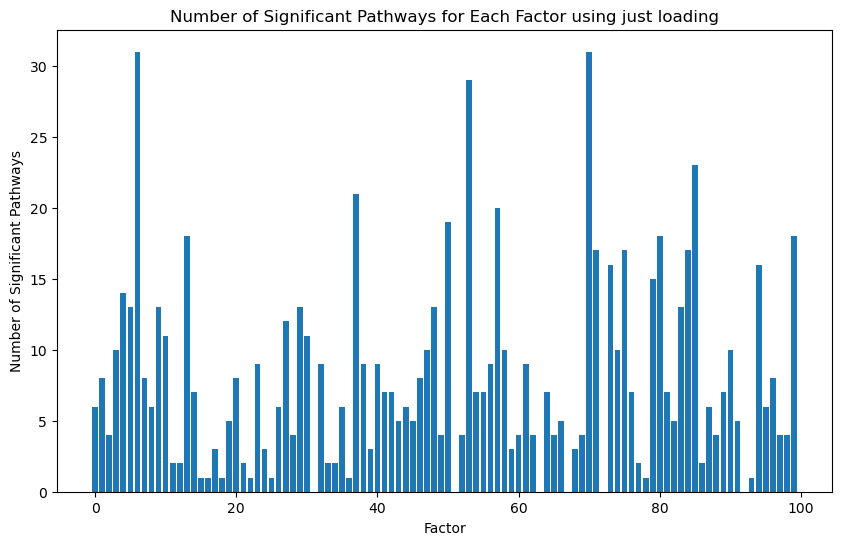

In [16]:
# plot the number of significant pathways for each factor
plt.figure(figsize=(10, 6))
# x-axis just use a number 0, 1, 2, ..., k-1
plt.bar(range(k), list(summary.values()))
plt.xlabel("Factor")
plt.ylabel("Number of Significant Pathways")
plt.title("Number of Significant Pathways for Each Factor using just loading")
plt.show()

### Systematic comparisons of L vs. -log10(q) * L
- Compare distributions: plot per-factor |L| vs -log10(q) and color by stability; look for rightmost points (big |L|) with low -log10(q) and low stability.
- Correlate ranks: Spearman between loading-only rank and q-weighted rank per factor.
- Count overlap at top N: |topN(load) ∩ topN(q-weighted)| / N.
- Track BH load: for each factor, plot empirical CDF of p and overlay BH threshold lines.

In [21]:
import numpy as np
import pandas as pd

L = np.asarray(post_bootstrap_adata.varm["fs_loadings"])
Q = np.asarray(post_bootstrap_adata.varm["fs_loading_q"])
stab = np.asarray(post_bootstrap_adata.varm["fs_loading_stability"])
genes = post_bootstrap_adata.var_names.to_numpy()
p, k = L.shape

Qc = np.clip(Q, 1e-300, 1.0)
rank_q = -np.log10(Qc) * L

summ = []
overlaps = []
for j in range(k):
    s_load = pd.Series(L[:, j], index=genes).sort_values(ascending=False)
    s_q = pd.Series(rank_q[:, j], index=genes).sort_values(ascending=False)
    # Spearman correlation between ranks (top direction)
    spearman = s_load.rank(ascending=False).corr(s_q.rank(ascending=False), method="spearman")
    # Top-N overlap
    N = 200
    top_load = set(s_load.index[:N])
    top_q = set(s_q.index[:N])
    overlap = len(top_load & top_q) / float(N)
    overlaps.append(overlap)
    # Summaries
    summ.append({
        "factor": j,
        "spearman_rank_corr": spearman,
        "topN_overlap": overlap,
        "n_sig_q005": int((Q[:, j] < 0.05).sum()),
        "median_stability": float(np.median(stab[:, j])),
        "median_abs_loading": float(np.median(np.abs(L[:, j]))),
    })
diag_df = pd.DataFrame(summ).sort_values("spearman_rank_corr", ascending=True)


In [22]:
diag_df

,factor,spearman_rank_corr,topN_overlap,n_sig_q005,median_stability,median_abs_loading
96,96,0.975763,0.565,1026,0.00,0.014102
53,53,0.984664,0.680,12013,0.00,0.016764
50,50,0.986794,0.380,1955,0.00,0.010684
69,69,0.988268,0.635,1918,0.00,0.007895
80,80,0.990117,0.495,7737,0.00,0.014790
...,...,...,...,...,...,...
10,10,0.999989,0.905,0,0.00,0.007111
4,4,0.999994,0.935,0,0.01,0.006826
31,31,0.999999,0.990,1,0.01,0.006694
78,78,0.999999,0.975,12,0.00,0.005437


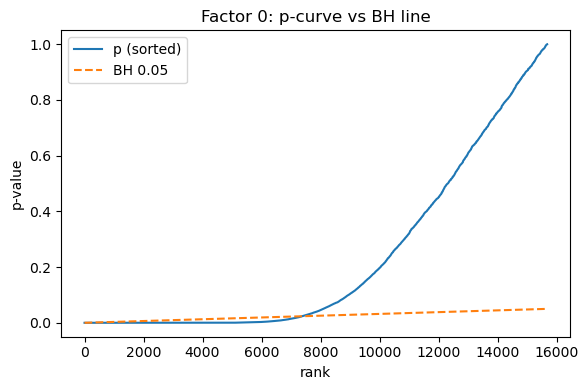

In [24]:
import matplotlib.pyplot as plt

j = 0
pvals = np.asarray(post_bootstrap_adata.varm.get("fs_loading_p", np.minimum(Q, 1.0)))[:, j]
pvals = np.clip(pvals, 1e-300, 1.0)
p_sorted = np.sort(pvals)
m = len(p_sorted)
bh_line = (np.arange(1, m+1) / m) * 0.05

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, m+1), p_sorted, label="p (sorted)")
plt.plot(np.arange(1, m+1), bh_line, ls="--", label="BH 0.05")
plt.xlabel("rank")
plt.ylabel("p-value")
plt.title(f"Factor {j}: p-curve vs BH line")
plt.legend()
plt.tight_layout()
plt.show()

Older stuff

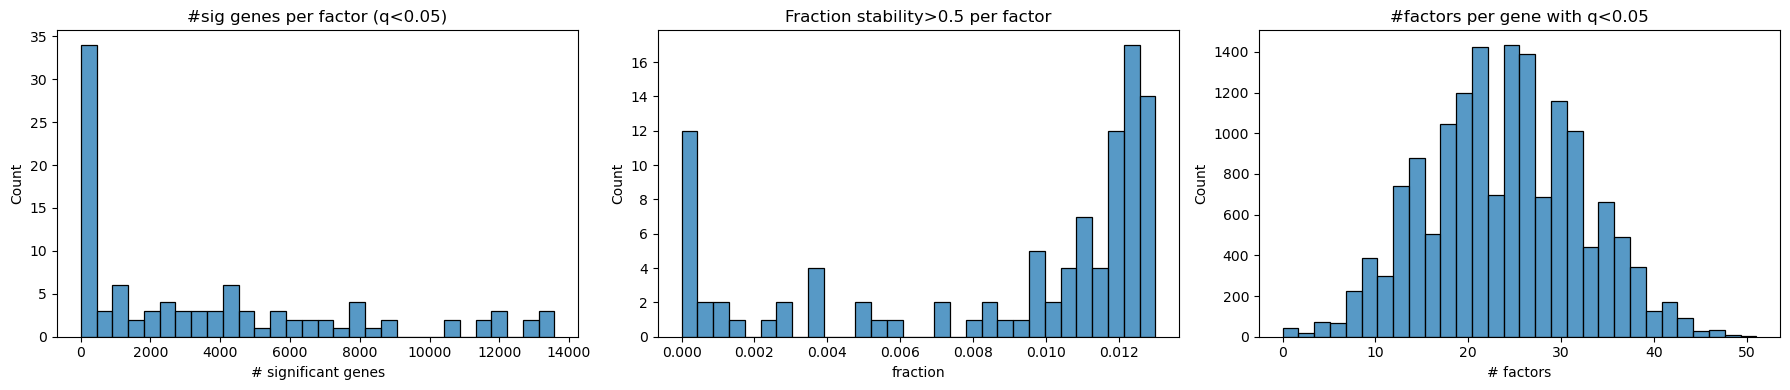

In [5]:
# Cell 5 — Optional: visualize distributions
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.histplot(sig_005, bins=30, ax=axes[0])
axes[0].set_title("#sig genes per factor (q<0.05)")
axes[0].set_xlabel("# significant genes")

sns.histplot(frac_stab_0p5, bins=30, ax=axes[1])
axes[1].set_title("Fraction stability>0.5 per factor")
axes[1].set_xlabel("fraction")

sns.histplot(sig_count_per_gene, bins=30, ax=axes[2])
axes[2].set_title("#factors per gene with q<0.05")
axes[2].set_xlabel("# factors")

plt.tight_layout()
plt.show()

### For a factor (0-based), inspect genes with high |loading| but low significance

In [ ]:
import numpy as np
import pandas as pd

L = np.asarray(post_bootstrap_adata.varm["fs_loadings"])               # (p, k)
Z_loading = np.asarray(post_bootstrap_adata.varm["fs_loading_z"])      # (p, k)
Q = np.asarray(post_bootstrap_adata.varm["fs_loading_q"])              # (p, k)
stab = np.asarray(post_bootstrap_adata.varm["fs_loading_stability"])   # (p, k)
genes = post_bootstrap_adata.var_names.to_numpy()
p, k = L.shape

# Choose a factor to inspect (0-based)
j = 0

df = pd.DataFrame({
    "gene": genes,
    "loading": L[:, j],
    "abs_loading": np.abs(L[:, j]),
    "z": Z_loading[:, j],
    "q": Q[:, j],
    "stability": stab[:, j],
}).sort_values("abs_loading", ascending=False)

# High effect but not significant (tune thresholds as needed)
hi_abs = df["abs_loading"].quantile(0.95)
candidates = df[(df["abs_loading"] >= hi_abs) & (df["q"] >= 0.10)].head(50)

x = L[:, j]
y = -np.log10(np.clip(Q[:, j], 1e-300, 1.0))
c = stab[:, j]

plt.figure(figsize=(6,4))
sc = plt.scatter(x, y, c=c, s=6, cmap="viridis")
plt.colorbar(sc, label="stability")
plt.axhline(-np.log10(0.05), color="tomato", lw=1, ls="--")
plt.xlabel("loading")
plt.ylabel("-log10(q)")
plt.title(f"Factor {j}: loading vs -log10(q)")
plt.tight_layout()
plt.show()